In [12]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [17]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [18]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
          'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [19]:
# Problem 1
rootdir ='notMNIST_small'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        print(filepath)
        #print(file)
        display(Image(filename=filepath))
        break
        
rootdir ='notMNIST_large'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        print(filepath)
        #print(file)
        display(Image(filename=filepath))
        break

notMNIST_small/J.pickle


ValueError: Cannot embed the 'pickle' image format

In [20]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

./notMNIST_large/A.pickle
./notMNIST_large/B.pickle
./notMNIST_large/C.pickle
./notMNIST_large/D.pickle
./notMNIST_large/E.pickle
./notMNIST_large/F.pickle
./notMNIST_large/G.pickle
./notMNIST_large/H.pickle
./notMNIST_large/I.pickle
./notMNIST_large/J.pickle


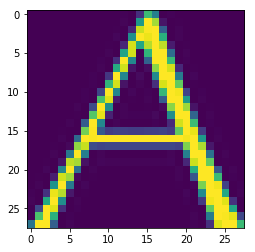

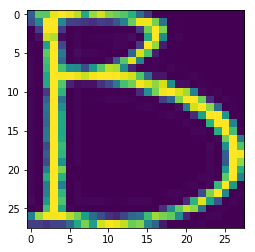

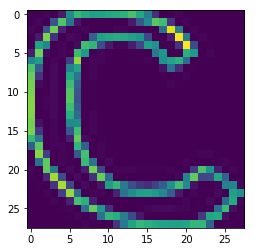

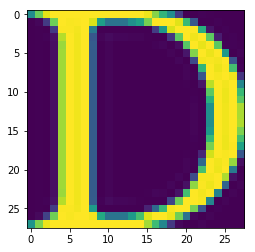

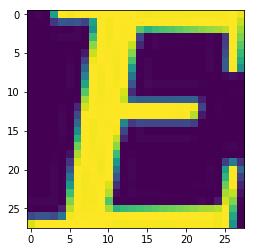

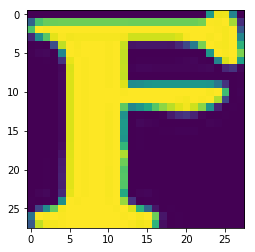

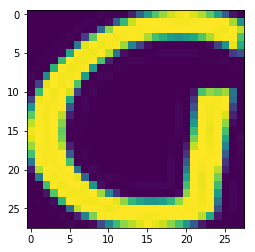

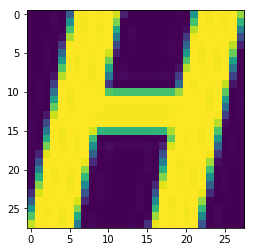

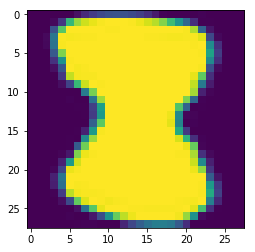

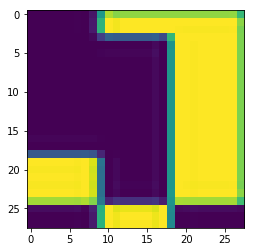

In [21]:
# Problem 2
i = 0
for element in train_datasets:
    print(element)
    data = pickle.load(open(element, "rb"))
    plt.figure(i)
    sample_idx = np.random.randint(len(data))
    plt.imshow(data[sample_idx,:,:])
    i = i + 1

In [37]:
# Problem 3
i = 0
for element in train_datasets:
    data = pickle.load(open(element, "rb"))
    print(element, " has ", len(data), " Elements with mean ",np.mean(data), " and std ", np.std(data), "\n")
    i = i + 1

./notMNIST_large/A.pickle  has  52909  Elements with mean  -0.12825  and std  0.443121 

./notMNIST_large/B.pickle  has  52911  Elements with mean  -0.00756304  and std  0.454491 

./notMNIST_large/C.pickle  has  52912  Elements with mean  -0.142258  and std  0.439806 

./notMNIST_large/D.pickle  has  52911  Elements with mean  -0.0573678  and std  0.455648 

./notMNIST_large/E.pickle  has  52912  Elements with mean  -0.0698989  and std  0.452942 

./notMNIST_large/F.pickle  has  52912  Elements with mean  -0.125583  and std  0.447089 

./notMNIST_large/G.pickle  has  52912  Elements with mean  -0.0945815  and std  0.44624 

./notMNIST_large/H.pickle  has  52912  Elements with mean  -0.0685223  and std  0.454232 

./notMNIST_large/I.pickle  has  52912  Elements with mean  0.0307862  and std  0.468899 

./notMNIST_large/J.pickle  has  52911  Elements with mean  -0.153358  and std  0.443656 



In [22]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [23]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

4
9
6
2
7
3
5
9
6
4
7


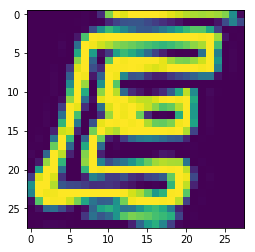

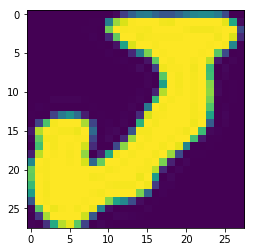

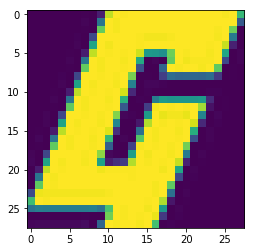

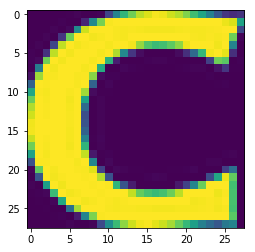

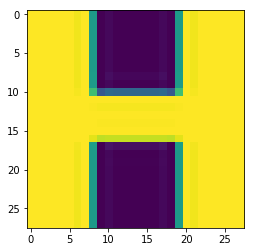

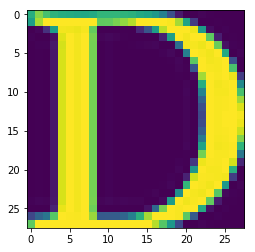

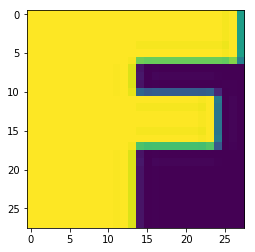

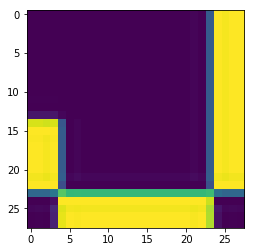

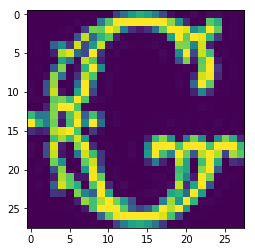

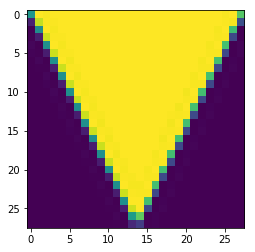

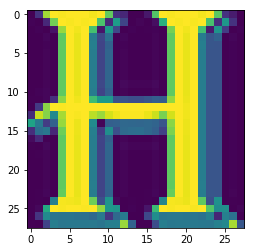

In [40]:
# Problem 4
i = 0;
for label in train_labels:
    print(train_labels[i])
    plt.figure(i)
    plt.imshow(train_dataset[i,:,:])
    i = i + 1
    if i > 10:
        break;

In [24]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [25]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [45]:
# Problem 5 --> too complex
def SSD(A,B):
    s = np.sum((A[:,:]-B[:,:])**2)
    return s

thresh = 0;
overlap_test = 0;
overlap_valid = 0;
counter = 0;
print_thresh = np.round(len(train_dataset) / 100)
cur_print_thresh = print_thresh
for img_train in train_dataset:
    # check overlap with test dataset
    for img_test in test_dataset:
        if SSD(img_train, img_test) <= thresh:
            overlap_test = overlap_test + 1;
    # check overlap with validation dataset
    for img_valid in valid_dataset:
        if SSD(img_train, img_valid) <= thresh:
            overlap_valid = overlap_valid + 1;  
    if counter > cur_print_thresh:
        print("done with image ", counter, "out of ", len(train_dataset), end='\r')
        cur_print_thresh = cur_print_thresh + print_thresh;
        counter = counter + 1
print("Overlap of training and test dataset: ", overlap_test)
print("Overlap of training and validation dataset: ", overlap_valid)           

KeyboardInterrupt: 

In [1]:
# Problem 6
from sklearn.linear_model import LogisticRegression
test_dataset_size = 100
for i in [50, 100, 1000, 5000]:
    
    #### get data ###
    
    used_train_dataset = train_dataset[:i,:,:]
    # reshape data
    nsamples, nx, ny = used_train_dataset.shape
    d2_used_train_dataset = used_train_dataset.reshape((nsamples,nx*ny))

    used_test_datset = test_dataset[:test_dataset_size,:,:]
    # reshape data
    nsamples, nx, ny = used_test_datset.shape
    d2_used_test_datset = used_test_datset.reshape((nsamples,nx*ny))
    # get subset of labels
    used_train_labels = train_labels[:i]
    used_test_labels = test_labels[:test_dataset_size]

    #### performe and evalualte regression ####
    
    # Create logistic regression object
    regr = LogisticRegression()

    # Train the model using the training sets
    regr.fit(d2_used_train_dataset, used_train_labels)
       
    # calculate and print the score
    score = regr.score(d2_used_test_datset, used_test_labels)
    print(i, score)

NameError: name 'train_dataset' is not defined